# CS 559 Homework 8

# Decision Tree and Stacking Method 

Upload the wine.data dataset as done in the lecture notebook and split into train and test
sets with a ratio of 7 to 3

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.columns = ['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols',
                    'Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']
df_wine

train_data, test_data = train_test_split(df_wine, test_size=0.3, random_state=42)

train_data.head(), test_data.head()

(     Class label  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
 138            3    13.49        3.59  2.19               19.5         88   
 104            2    12.51        1.73  1.98               20.5         85   
 78             2    12.33        0.99  1.95               14.8        136   
 36             1    13.28        1.64  2.84               15.5        110   
 93             2    12.29        2.83  2.22               18.0         88   
 
      Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
 138           1.62        0.48                  0.58             0.88   
 104           2.20        1.92                  0.32             1.48   
 78            1.90        1.85                  0.35             2.76   
 36            2.60        2.68                  0.34             1.36   
 93            2.45        2.25                  0.25             1.99   
 
      Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
 138           

Test Error Decomposition. Using sklearn SVM, predict the alcohol level and
estimate the bias2 and variance errors as the model becomes complex

In [9]:
import numpy as np
from itertools import combinations
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

def calculate_bias_variance(y_true, y_prediction):
    avg_prediction = np.mean(y_prediction, axis=0)
    bias_squared = np.mean((y_true - avg_prediction) ** 2)
    variance = np.mean(np.var(y_prediction, axis=0))
    return bias_squared, variance

scaler = StandardScaler()
X_train = scaler.fit_transform(train_data.drop('Class label',axis=1))
y_train = train_data['Class label']
X_test = scaler.transform(test_data.drop('Class label',axis=1))
y_test = test_data['Class label']

def estimate_bias_variance(X_train, y_train, X_test, y_test, max_features=12):
    results = {'n_features': [], 'train_bias2': [], 'train_variance': [], 'test_bias2': [], 'test_variance': []}
    n_samples = 10 
    
    for n_features in range(1, max_features + 1):
        feature_combinations = list(combinations(range(X_train.shape[1]), n_features))
        train_bias2, train_variance, test_bias2, test_variance = [], [], [], []
        
        for comb in feature_combinations:
            X_train_subset = X_train[:, comb]
            X_test_subset = X_test[:, comb]
            
            y_train_prediction = []
            y_test_prediction = []
            
            for _ in range(n_samples):
                model = SVR(kernel='linear')
                model.fit(X_train_subset, y_train)
                y_train_prediction.append(model.predict(X_train_subset))
                y_test_prediction.append(model.predict(X_test_subset))
            
            y_train_prediction = np.array(y_train_prediction)
            y_test_prediction = np.array(y_test_prediction)
            
            train_b2, train_var = calculate_bias_variance(y_train, y_train_prediction)
            test_b2, test_var = calculate_bias_variance(y_test, y_test_prediction)
            
            train_bias2.append(train_b2)
            train_variance.append(train_var)
            test_bias2.append(test_b2)
            test_variance.append(test_var)
        
        results['n_features'].append(n_features)
        results['train_bias2'].append(np.mean(train_bias2))
        results['train_variance'].append(np.mean(train_variance))
        results['test_bias2'].append(np.mean(test_bias2))
        results['test_variance'].append(np.mean(test_variance))
    
    return results

results = estimate_bias_variance(X_train, y_train, X_test, y_test)

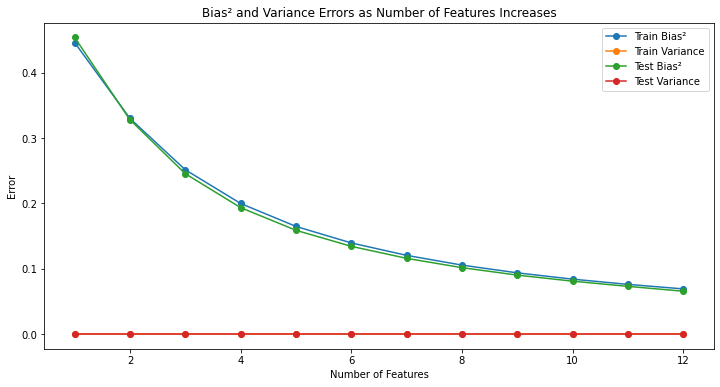

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results['n_features'], results['train_bias2'], label='Train Bias²', marker='o')
plt.plot(results['n_features'], results['train_variance'], label='Train Variance', marker='o')
plt.plot(results['n_features'], results['test_bias2'], label='Test Bias²', marker='o')
plt.plot(results['n_features'], results['test_variance'], label='Test Variance', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Error')
plt.title('Bias² and Variance Errors as Number of Features Increases')
plt.legend()
plt.show()

The best number of features is 12 as it has the minimized error

Decision Tree. Explain how the variance error would change as the decision tree
model becomes more complex. Train a sklearn decision tree model that predicts alcohol
levels. Then, generalize the model. Report and visualize the change of variance errors as
the depth number increases. Explain the agreement/disagreement between the expectation
and the results.

As the decision tree becomes more complex, the variance error increases beacsue it tends to capture more noice leading to overfitting

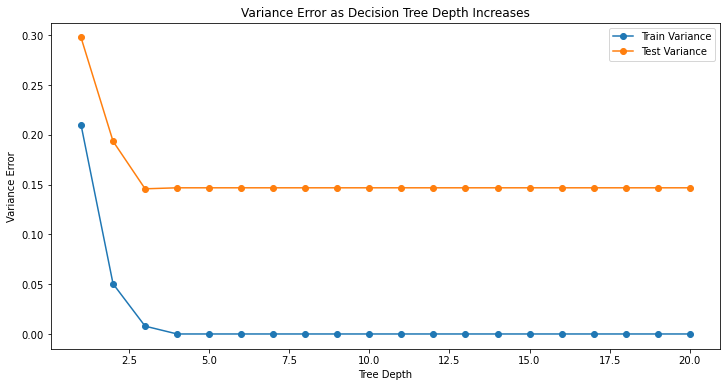

In [14]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_variance(X_train, y_train, X_test, y_test, max_depth=20):
    train_variance, test_variance = [], []
    
    for depth in range(1, max_depth + 1):
        model = DecisionTreeRegressor(max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        
        y_train_prediction = model.predict(X_train)
        y_test_prediction = model.predict(X_test)
        
        train_variance.append(np.var(y_train - y_train_prediction))
        test_variance.append(np.var(y_test - y_test_prediction))
    
    return train_variance, test_variance

train_variance, test_variance = decision_tree_variance(X_train, y_train, X_test, y_test)

plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), train_variance, label='Train Variance', marker='o')
plt.plot(range(1, 21), test_variance, label='Test Variance', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Variance Error')
plt.title('Variance Error as Decision Tree Depth Increases')
plt.legend()
plt.show()

The disagreement between the expectation and results is likely due to the model capturing the patterns of the data, which decreases the variance error initially. However, after the initial decrease, it can be observed that the variance error does not change signifying that adding more depth does not impact the model as the tree has already captured the important patterns. 

Stacking Method. Explain the expectation of bias2 error in the stacking method
between base learners and meta-learner. Build a sklearn stacking model that predicts the
alcohol levels. Then, generalize the model. Visualize the weight of base learners and determine the most contributed base learner. Compare the meta-learner bias2 error to the base
learners’ bias2 errors. Explain if the result agrees with the expectation

It is expected that the bias error in the stacking method will be reduced as the meta learner combines the strengths of the two base models.

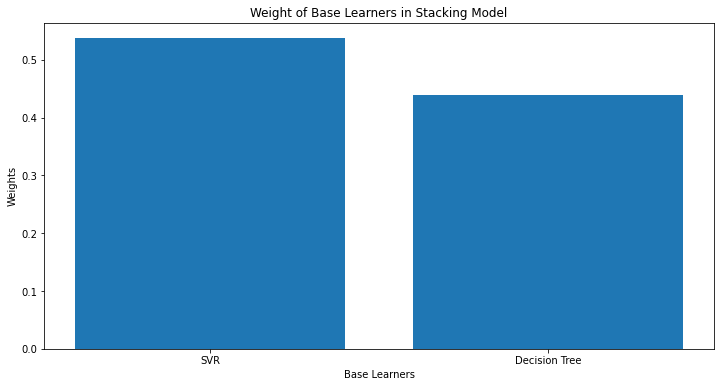

Meta-Learner Train Bias²: 0.02012544304192308, Test Bias²: 0.0669269708644539
svr Train Bias²: 0.06317067728580088, Test Bias²: 0.05847397930909554
dt Train Bias²: 0.0, Test Bias²: 0.14814814814814814


In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

base_learners = [
    ('svr', SVR(kernel='linear')),
    ('dt', DecisionTreeRegressor(max_depth=20, random_state=42))
]

meta_learner = LinearRegression()

stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_learner, cv=5)
stacking_model.fit(X_train, y_train)

y_train_prediction = stacking_model.predict(X_train)
y_test_prediction = stacking_model.predict(X_test)

train_bias2, train_variance = calculate_bias_variance(y_train, np.array([y_train_prediction]))
test_bias2, test_variance = calculate_bias_variance(y_test, np.array([y_test_prediction]))

weights = stacking_model.final_estimator_.coef_

plt.figure(figsize=(12, 6))
plt.bar(['SVR', 'Decision Tree'], weights)
plt.xlabel('Base Learners')
plt.ylabel('Weights')
plt.title('Weight of Base Learners in Stacking Model')
plt.show()

print(f'Meta-Learner Train Bias²: {train_bias2}, Test Bias²: {test_bias2}')

for name, estimator in base_learners:
    estimator.fit(X_train, y_train)
    y_train_base_prediction = estimator.predict(X_train)
    y_test_base_prediction = estimator.predict(X_test)
    train_base_bias2, _ = calculate_bias_variance(y_train, np.array([y_train_base_prediction]))
    test_base_bias2, _ = calculate_bias_variance(y_test, np.array([y_test_base_prediction]))
    print(f'{name} Train Bias²: {train_base_bias2}, Test Bias²: {test_base_bias2}')

The SVR was the most contributed model in the stacking method. The meta learner's train bias decreased from the svr train bias but increased from the decision tree train bias. The meta learner's test bias increased from the svr test bias but decreased from the decision tree test bias. 